# setting tensorflow-gpu

### my GPU
```
GeForce GTX 1060 3GB
```

### install guide

```
cuda-10.1
cuDNN-7

위 버전으로 설치해야됨
```

pip install tensorflow-gpu==2.3.1  

https://www.tensorflow.org/install/gpu

https://developer.nvidia.com/cuda-toolkit-archive

https://developer.nvidia.com/cuda-11.1.0-download-archive # 오류

Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found

https://developer.nvidia.com/cuda-10.1-download-archive-update2 # 해결

Could not load dynamic library 'cudnn64_7.dll'; dlerror: cudnn64_7.dll not found

https://developer.nvidia.com/cudnn # 해결

Download cuDNN v7.6.5 (November 5th, 2019), for CUDA 10.1

### for windows
```
SET PATH=C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\bin;%PATH%
SET PATH=C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\extras\CUPTI\lib64;%PATH%
SET PATH=C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\include;%PATH%
SET PATH=C:\cuda\bin;%PATH%
```

## test

python gpu_test.py

---

# first MNIST

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

```
keras에 datasets에 mnist 객체에 load_data() 함수를 사용하여 학습용 데이터, 테스트용 데이터를 불러온다

x_train의 경우 600,000개의 28x28 이미지
y_train의 경우 600,000개 이미지에 대한 레이블

x_test, y_test는 위 포맷과 동일하나 테스트용 데이터이다
```

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
y_train.shape

(60000,)

In [5]:
x_test.shape

(10000, 28, 28)

In [6]:
y_test.shape

(10000,)

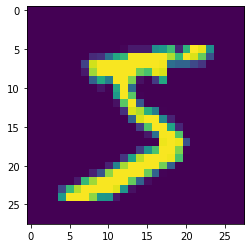

In [7]:
plt.imshow(x_train[0])

In [8]:
y_train[0]

5

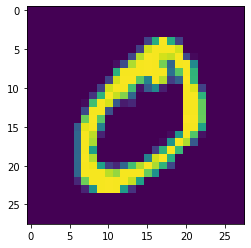

In [9]:
plt.imshow(x_train[1])

In [10]:
y_train[1]

0

### 이미지를 255로 나누는 이유

https://stackoverflow.com/questions/20486700/why-do-we-always-divide-rgb-values-by-255#:~:text=Since%20255%20is%20the%20maximum,when%20using%20floating%20point%20values.

```
R,G,B 가 0~255의 범위를 가지는데
255로 나눌 경우 범위가 0~1로 축소된다
```

In [11]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [12]:
# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [14]:
train_ds

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>

In [15]:
test_ds

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.uint8)>

In [16]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

In [17]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

In [18]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [19]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [20]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [21]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 0.13365963101387024, Accuracy: 95.98833465576172, Test Loss: 0.05797918885946274, Test Accuracy: 97.94999694824219
Epoch 2, Loss: 0.041169580072164536, Accuracy: 98.72666931152344, Test Loss: 0.05366230383515358, Test Accuracy: 98.18000030517578
Epoch 3, Loss: 0.020754607394337654, Accuracy: 99.31666564941406, Test Loss: 0.05250551179051399, Test Accuracy: 98.33999633789062
Epoch 4, Loss: 0.012172190472483635, Accuracy: 99.60166931152344, Test Loss: 0.057840388268232346, Test Accuracy: 98.31999969482422
Epoch 5, Loss: 0.00913364440202713, Accuracy: 99.70999908447266, Test Loss: 0.06316427141427994, Test Accuracy: 98.37999725341797


In [25]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  320       
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  2769024   
_________________________________________________________________
dense_1 (Dense)              multiple                  1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________
